Importing all necessary package

In [2]:
import numpy as np
import pandas as pd
import math
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn import tree
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

Reading the data

In [4]:
data = pd.read_csv("/content/train-chennai-sale.csv")
pd.set_option('display.max_columns', None)
data.head(3)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,INF_PRICE,1+0.04,"POWER(Z,Y)",SALES_PRICE
0,P09411,Anna Nagar,1986,19-12-2006,2.0,1.0,5,Ab Normal,No,22-12-1995,Commercial,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,40676975.91,1.04,1.872981,21717770
1,P05346,Velachery,1855,13-03-2010,3.0,2.0,5,Family,No,18-03-1988,Others,NoSewer,Paved,I,4.7,3.9,3.6,4.010,356321,77042,15418404.56,1.04,1.601032,9630290
2,P00219,Chrompet,1220,11/9/2014,2.0,1.0,4,Partial,No,12/9/2009,Commercial,NoSewer,No Access,RH,4.5,2.6,3.1,3.320,409027,198316,16963071.24,1.04,1.368569,12394750


Data cleaning

In [29]:
data = pd.read_csv("/content/train-chennai-sale.csv")
data.dropna(inplace=True)
data.columns = data.columns.str.lower()
data.area = data.area.str.lower()
data.sale_cond = data.sale_cond.str.lower()
data.sale_cond = data.sale_cond.replace({'adj land':'adjland',
                       'normal sale':'normal sale',
                       'partiall':'partial',
                       'ab normal':'abnormal'})
data.park_facil = data.park_facil.str.lower()
data.buildtype = data.buildtype.str.lower()
data.buildtype = data.buildtype.replace({'comercial':'commercial',
                       'others':'other'})
data.buildtype = data.buildtype.replace({'comercial':'commercial',
                       'others':'other'})
data.utility_avail = data.utility_avail.str.lower()
data.street = data.street.str.lower()
data.mzzone = data.mzzone.str.lower()

data.n_bedroom = data.n_bedroom.astype(int)
data.n_bathroom = data.n_bathroom.astype(int)

df = pd.DataFrame(data)

def normalize_date(date_str):
    if '/' in date_str:
        parts = date_str.split('/')
        if len(parts) == 3:
            return f"{parts[1]}-{parts[0]}-{parts[2]}"
    elif '-' in date_str:
        return date_str
    return None
df['date_sale'] = df['date_sale'].apply(normalize_date)
df['date_build'] = df['date_build'].apply(normalize_date)

# Convert the date column to datetime with the format '%d-%m-%Y'( here data.date_sale is df['date_sale'])

data.date_sale = pd.to_datetime(df['date_sale'], format='%d-%m-%Y')
data.date_build = pd.to_datetime(df['date_build'], format='%d-%m-%Y')

data['property_age'] = pd.DatetimeIndex(data.date_sale).year - pd.DatetimeIndex(data.date_build).year

data['total_price'] = pd.DataFrame(data.reg_fee	+ data.commis	+ data.sales_price)

data = data.reindex(columns = ['prt_id', 'area', 'sale_cond', 'park_facil',
       'buildtype', 'utility_avail', 'street', 'mzzone',
       'date_build', 'date_sale', 'property_age',
       'int_sqft', 'n_bedroom','n_bathroom', 'n_room',
       'qs_rooms', 'qs_bathroom', 'qs_bedroom', 'qs_overall',
       'reg_fee', 'commis', 'sales_price', 'total_price'])

data.head(3)



,prt_id,area,sale_cond,park_facil,buildtype,utility_avail,street,mzzone,date_build,date_sale,property_age,int_sqft,n_bedroom,n_bathroom,n_room,qs_rooms,qs_bathroom,qs_bedroom,qs_overall,reg_fee,commis,sales_price,total_price
0,P09411,anna nagar,abnormal,no,commercial,allpub,gravel,rh,1995-12-22,2006-12-19,11,1986,2,1,5,4.9,4.2,2.5,3.765,760122,304049,21717770,22781941
1,P05346,velachery,family,no,other,nosewer,paved,i,1988-03-18,2010-03-13,22,1855,3,2,5,4.7,3.9,3.6,4.010,356321,77042,9630290,10063653
2,P00219,chrompet,partial,no,commercial,nosewer,no access,rh,2009-12-09,2014-11-09,5,1220,2,1,4,4.5,2.6,3.1,3.320,409027,198316,12394750,13002093


 Correlation between target and features which are shown in reddish colour.

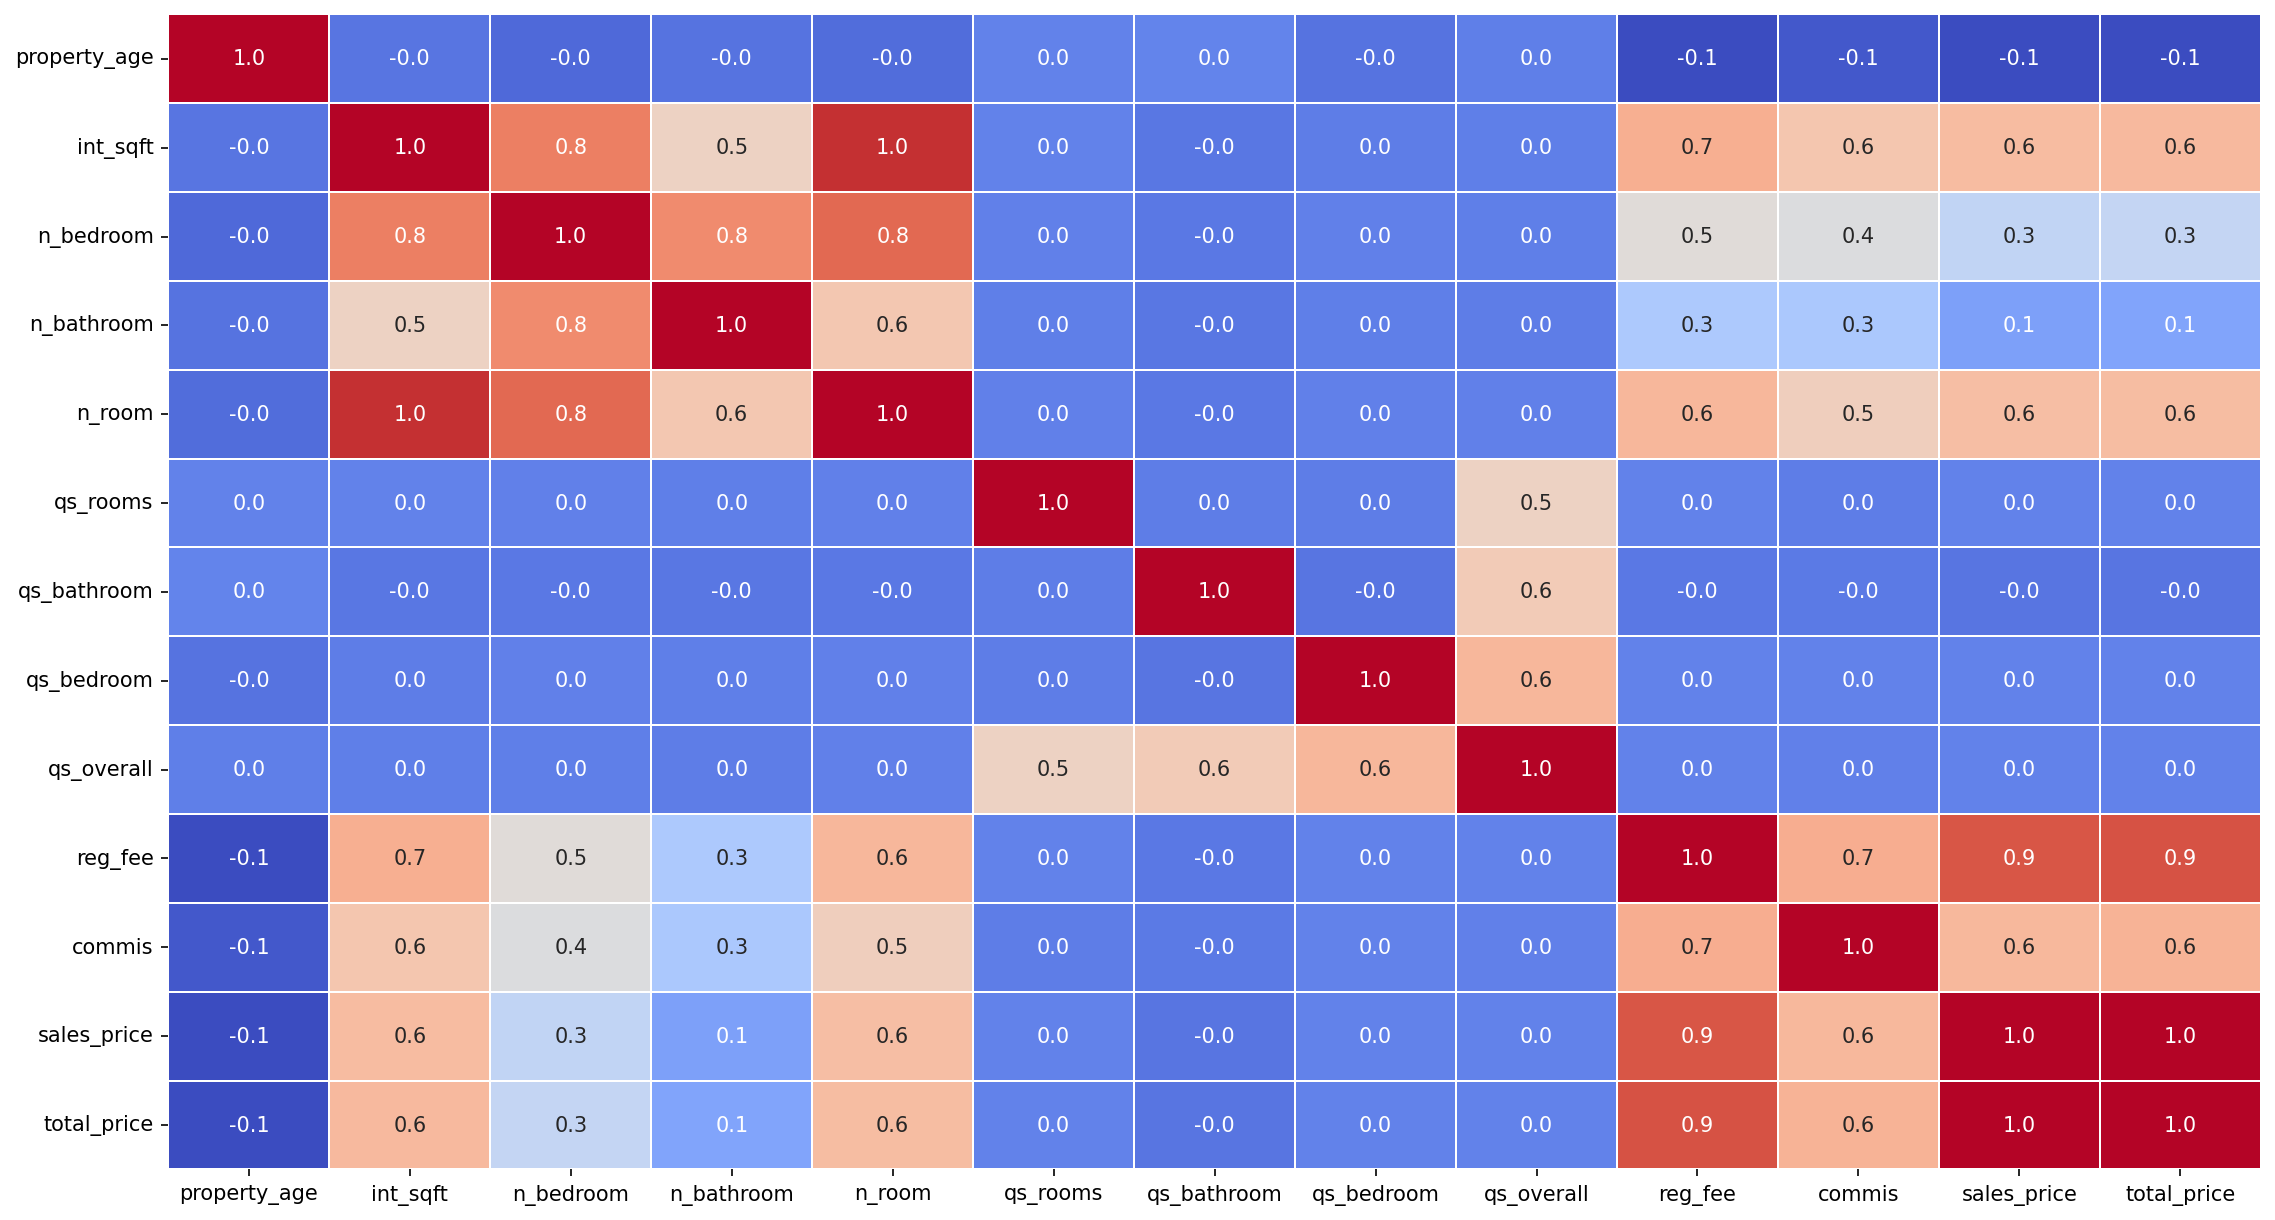

In [16]:
plt.figure(figsize=(18,10), dpi=150)
sns.heatmap(data.corr(method='pearson'), cbar=False, annot=True, fmt='.1f', linewidth=0.2, cmap='coolwarm');

**Distribution Of Features in Data Columns**

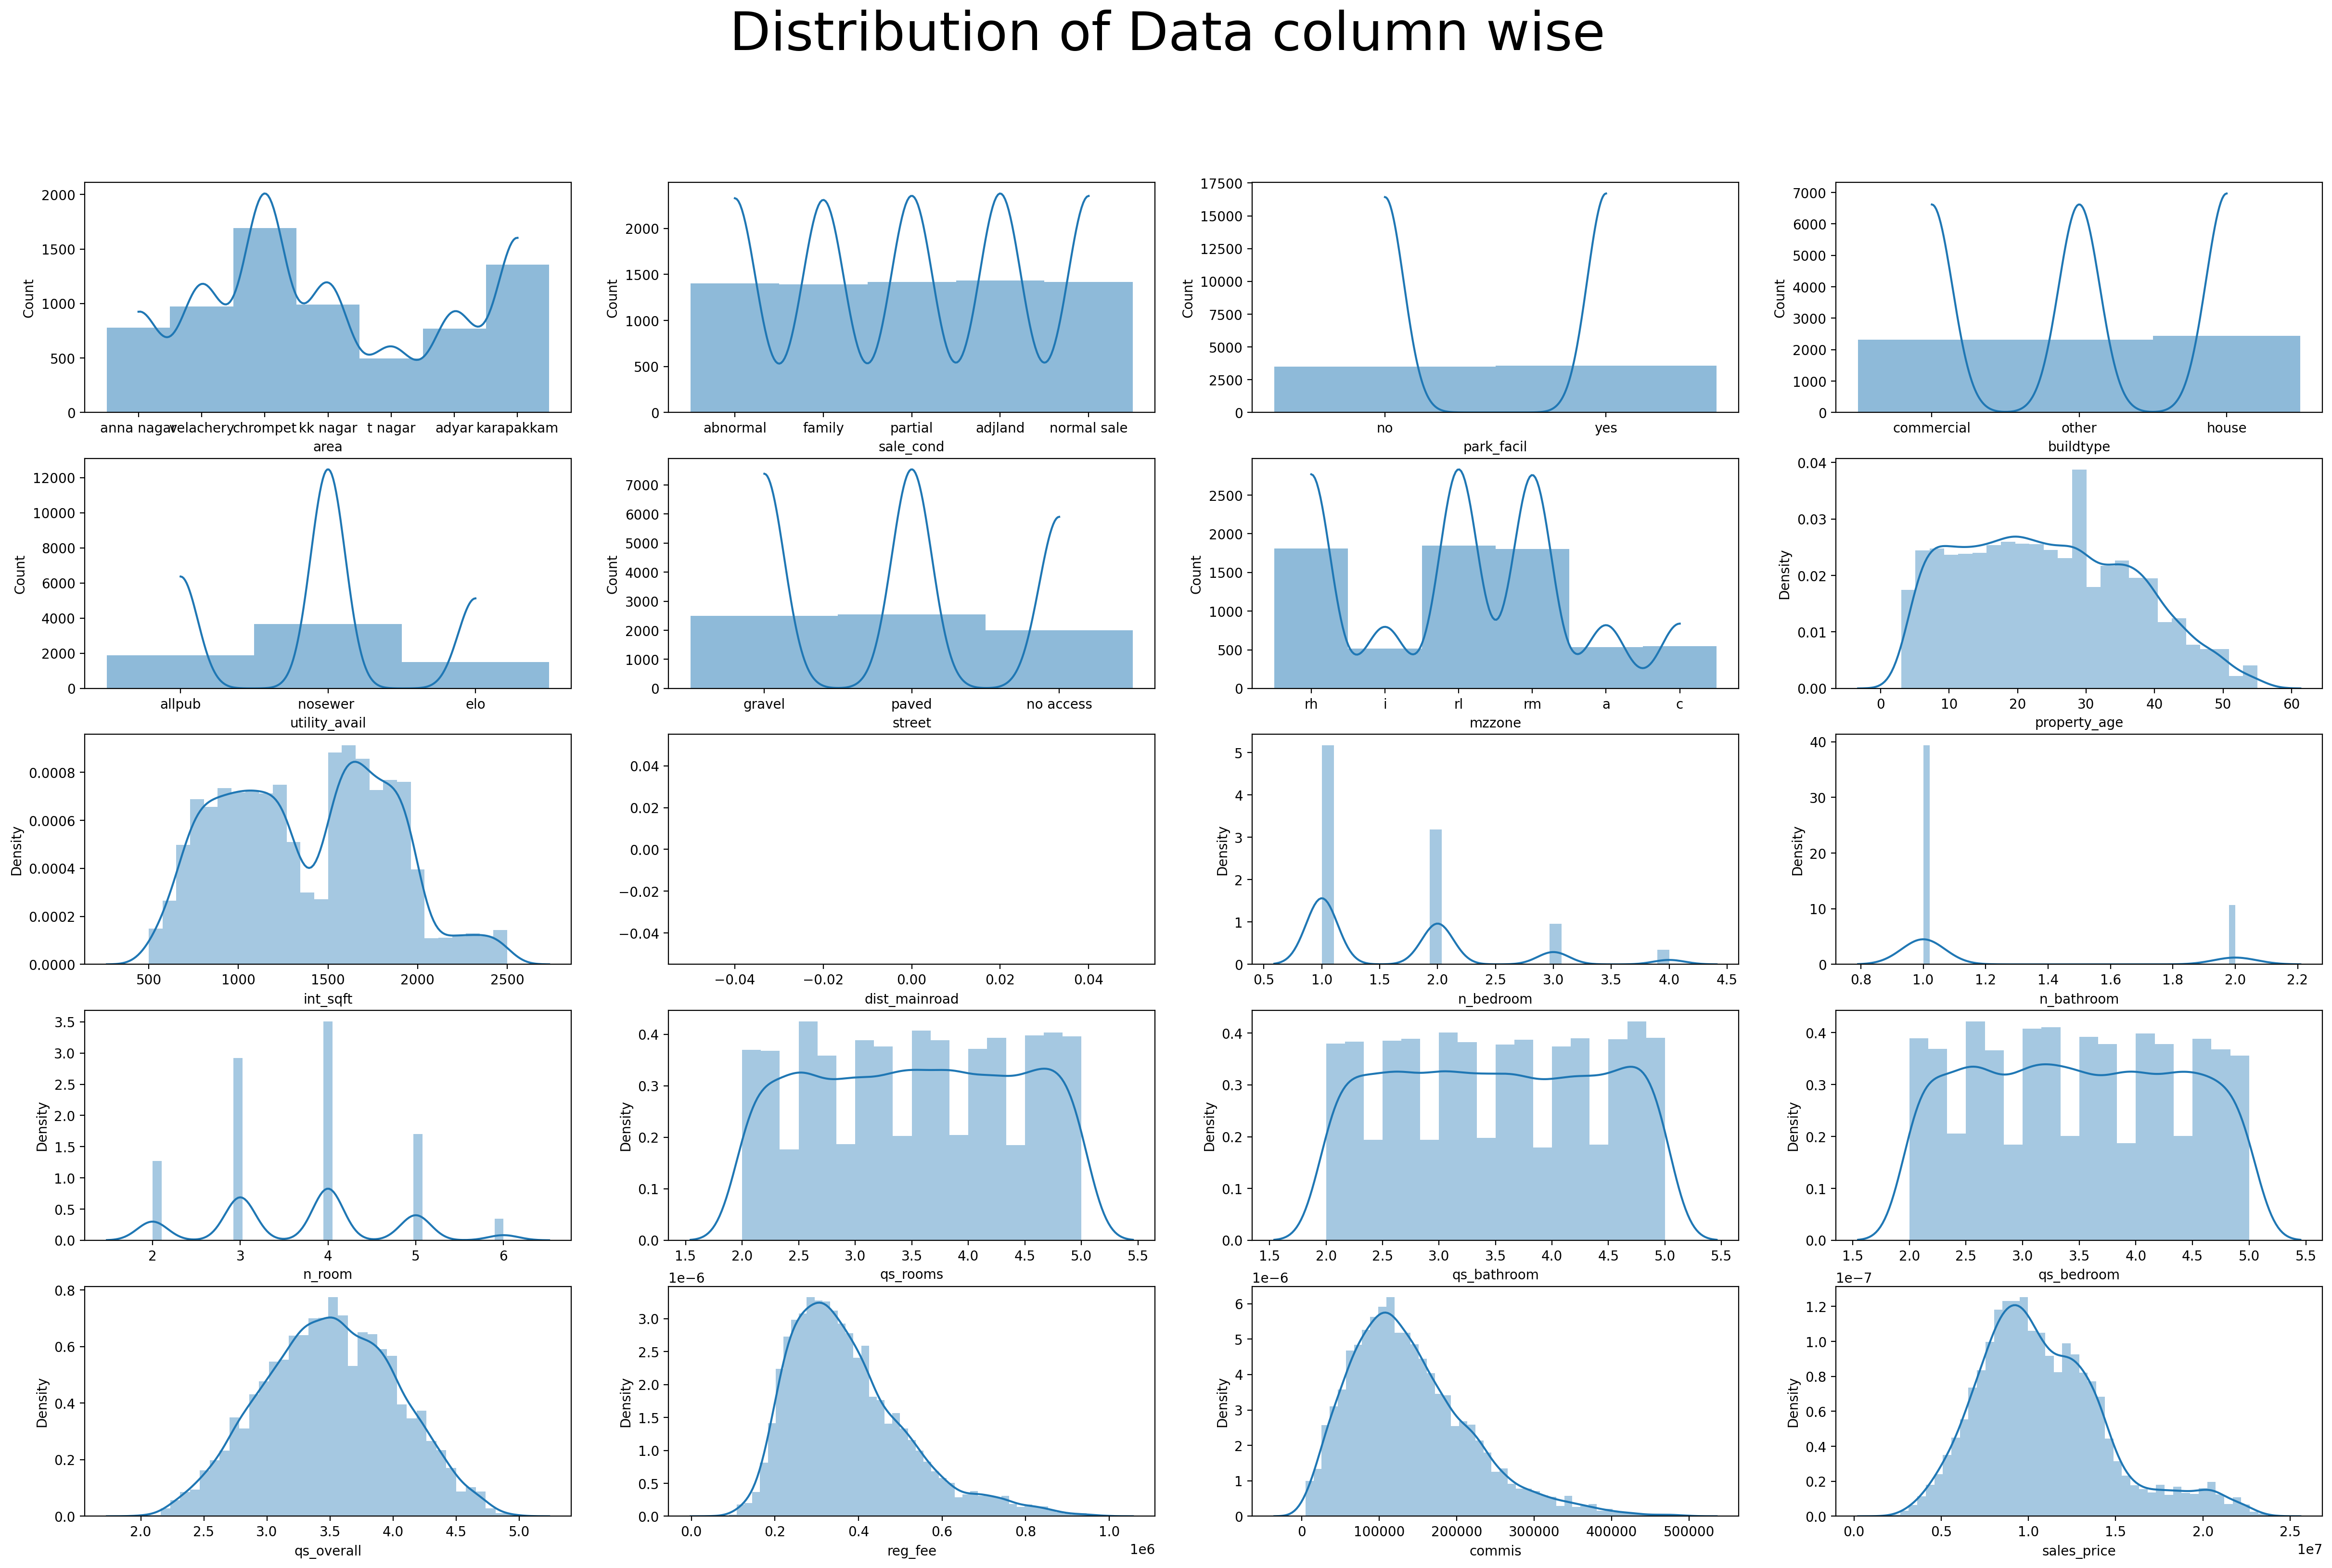

In [6]:
plt.figure(figsize=(30, 18), dpi=200)

plt.subplot(5,4,1)
sns.histplot(data.area, linewidth=0,kde=True)

plt.subplot(5,4,2)
sns.histplot(data.sale_cond, linewidth=0,kde=True)

plt.subplot(5,4,3)
sns.histplot(data.park_facil, linewidth=0,kde=True)

plt.subplot(5,4,4)
sns.histplot(data.buildtype, linewidth=0,kde=True)

plt.subplot(5,4,5)
sns.histplot(data.utility_avail, linewidth=0,kde=True)

plt.subplot(5,4,6)
sns.histplot(data.street, linewidth=0,kde=True)

plt.subplot(5,4,7)
sns.histplot(data.mzzone, linewidth=0,kde=True)

plt.subplot(5,4,8)
sns.distplot(data.property_age)

plt.subplot(5,4,9)
sns.distplot(data.int_sqft)

plt.subplot(5,4,10)
sns.distplot(data.dist_mainroad)

plt.subplot(5,4,11)
sns.distplot(data.n_bedroom)

plt.subplot(5,4,12)
sns.distplot(data.n_bathroom)

plt.subplot(5,4,13)
sns.distplot(data.n_room)

plt.subplot(5,4,14)
sns.distplot(data.qs_rooms)

plt.subplot(5,4,15)
sns.distplot(data.qs_bathroom)

plt.subplot(5,4,16)
sns.distplot(data.qs_bedroom)

plt.subplot(5,4,17)
sns.distplot(data.qs_overall)

plt.subplot(5,4,18)
sns.distplot(data.reg_fee)

plt.subplot(5,4,19)
sns.distplot(data.commis)

plt.subplot(5,4,20)
sns.distplot(data.sales_price)

plt.suptitle("Distribution of Data column wise", fontsize=40)
plt.show()

**Plotting of Categorical data vs Target**

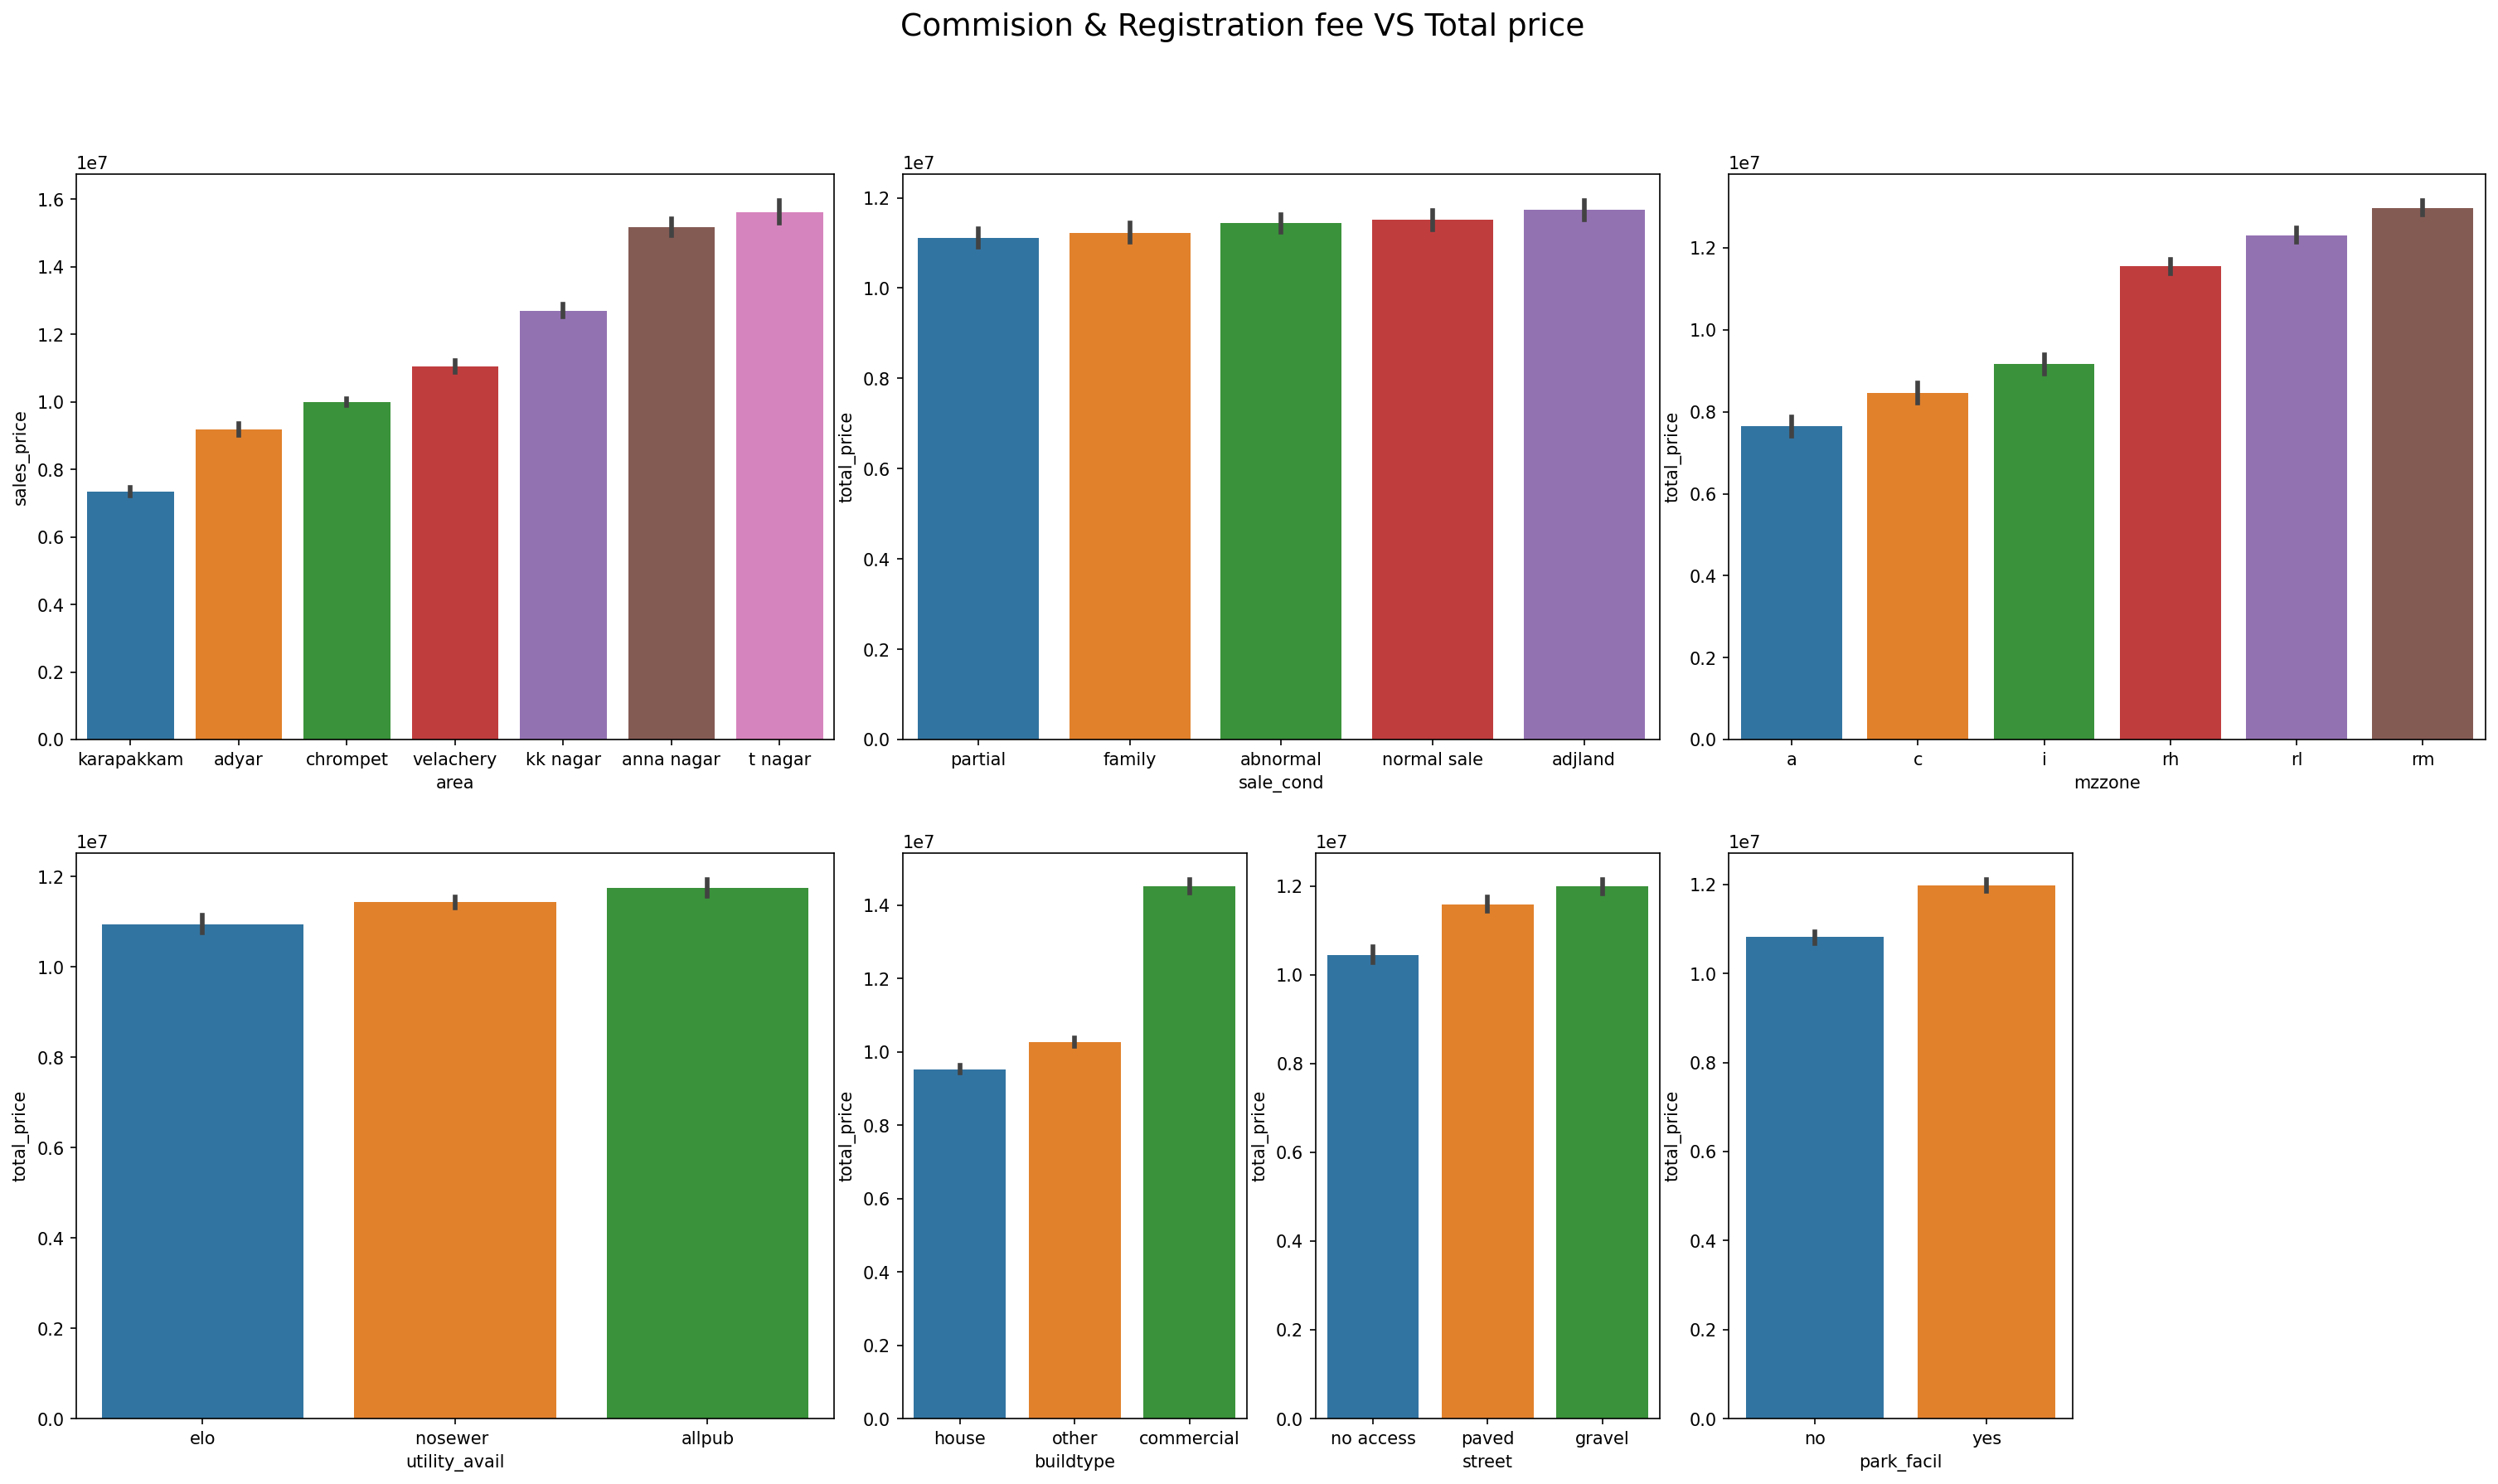

In [30]:
plt.figure(figsize=(25, 13), dpi=150)

plt.subplot2grid((2,6),(0,0),colspan=2)
sns.barplot(x=data.area,y=data.sales_price,order=data.groupby('area')['sales_price'].mean().reset_index().sort_values('sales_price')['area'])

plt.subplot2grid((2,6),(0,2),colspan=2)
sns.barplot(x=data.sale_cond,y=data.total_price,order=data.groupby('sale_cond')['total_price'].mean().reset_index().sort_values('total_price')['sale_cond'])

plt.subplot2grid((2,6),(0,4),colspan=2)
sns.barplot(x=data.mzzone,y=data.total_price,order=data.groupby('mzzone')['total_price'].mean().reset_index().sort_values('total_price')['mzzone'])

plt.subplot2grid((2,6),(1,0),colspan=2)
sns.barplot(x=data.utility_avail,y=data.total_price,order=data.groupby('utility_avail')['total_price'].mean().reset_index().sort_values('total_price')['utility_avail'])

plt.subplot2grid((2,6),(1,2))
sns.barplot(x=data.buildtype,y=data.total_price,order=data.groupby('buildtype')['total_price'].mean().reset_index().sort_values('total_price')['buildtype'])

plt.subplot2grid((2,6),(1,3))
sns.barplot(x=data.street,y=data.total_price,order=data.groupby('street')['total_price'].mean().reset_index().sort_values('total_price')['street'])

plt.subplot2grid((2,6),(1,4))
sns.barplot(x=data.park_facil,y=data.total_price,order=data.groupby('park_facil')['total_price'].mean().reset_index().sort_values('total_price')['park_facil'])

plt.suptitle("Commision & Registration fee VS Total price", fontsize=18)
plt.show()

In [31]:
data = pd.get_dummies(data,columns=['buildtype'])

**Label encoder(mapping)** and correlation graph

,area,sale_cond,park_facil,buildtype_commercial,buildtype_house,buildtype_other,utility_avail,street,mzzone,property_age,int_sqft,n_bedroom,n_bathroom,n_room,qs_rooms,qs_bathroom,qs_bedroom,qs_overall,reg_fee,commis,sales_price,total_price
0,6,3,0,1,0,0,4,3,4,11,1986,2,1,5,4.9,4.2,2.5,3.765,760122,304049,21717770,22781941
1,4,2,0,0,0,1,3,2,3,22,1855,3,2,5,4.7,3.9,3.6,4.010,356321,77042,9630290,10063653
2,3,1,0,1,0,0,3,1,4,5,1220,2,1,4,4.5,2.6,3.1,3.320,409027,198316,12394750,13002093
3,3,1,0,0,0,1,4,1,5,28,1167,1,1,3,3.6,2.1,2.5,2.670,263152,33955,8488790,8785897
4,4,2,0,1,0,0,4,3,6,10,1847,3,2,5,2.4,4.5,2.1,3.260,604809,235204,16800250,17640263
5,3,5,0,0,0,1,3,2,6,34,771,1,1,2,2.9,3.7,4.0,3.550,257578,33236,8308970,8599784
6,4,3,0,0,0,1,1,1,3,15,1635,2,1,4,3.1,3.1,3.3,3.160,323346,121255,8083650,8528251
7,3,1,0,0,0,1,3,3,6,37,1054,1,1,3,2.2,3.1,3.3,2.890,245693,141746,9449730,9837169
8,3,2,0,0,0,1,3,1,5,19,1196,1,1,3,2.1,2.5,2.1,2.260,289554,35097,8774370,9099021
9,4,2,0,1,0,0,3,2,6,54,1865,3,2,5,4.8,2.2,4.9,3.660,619987,294494,15499680,16414161


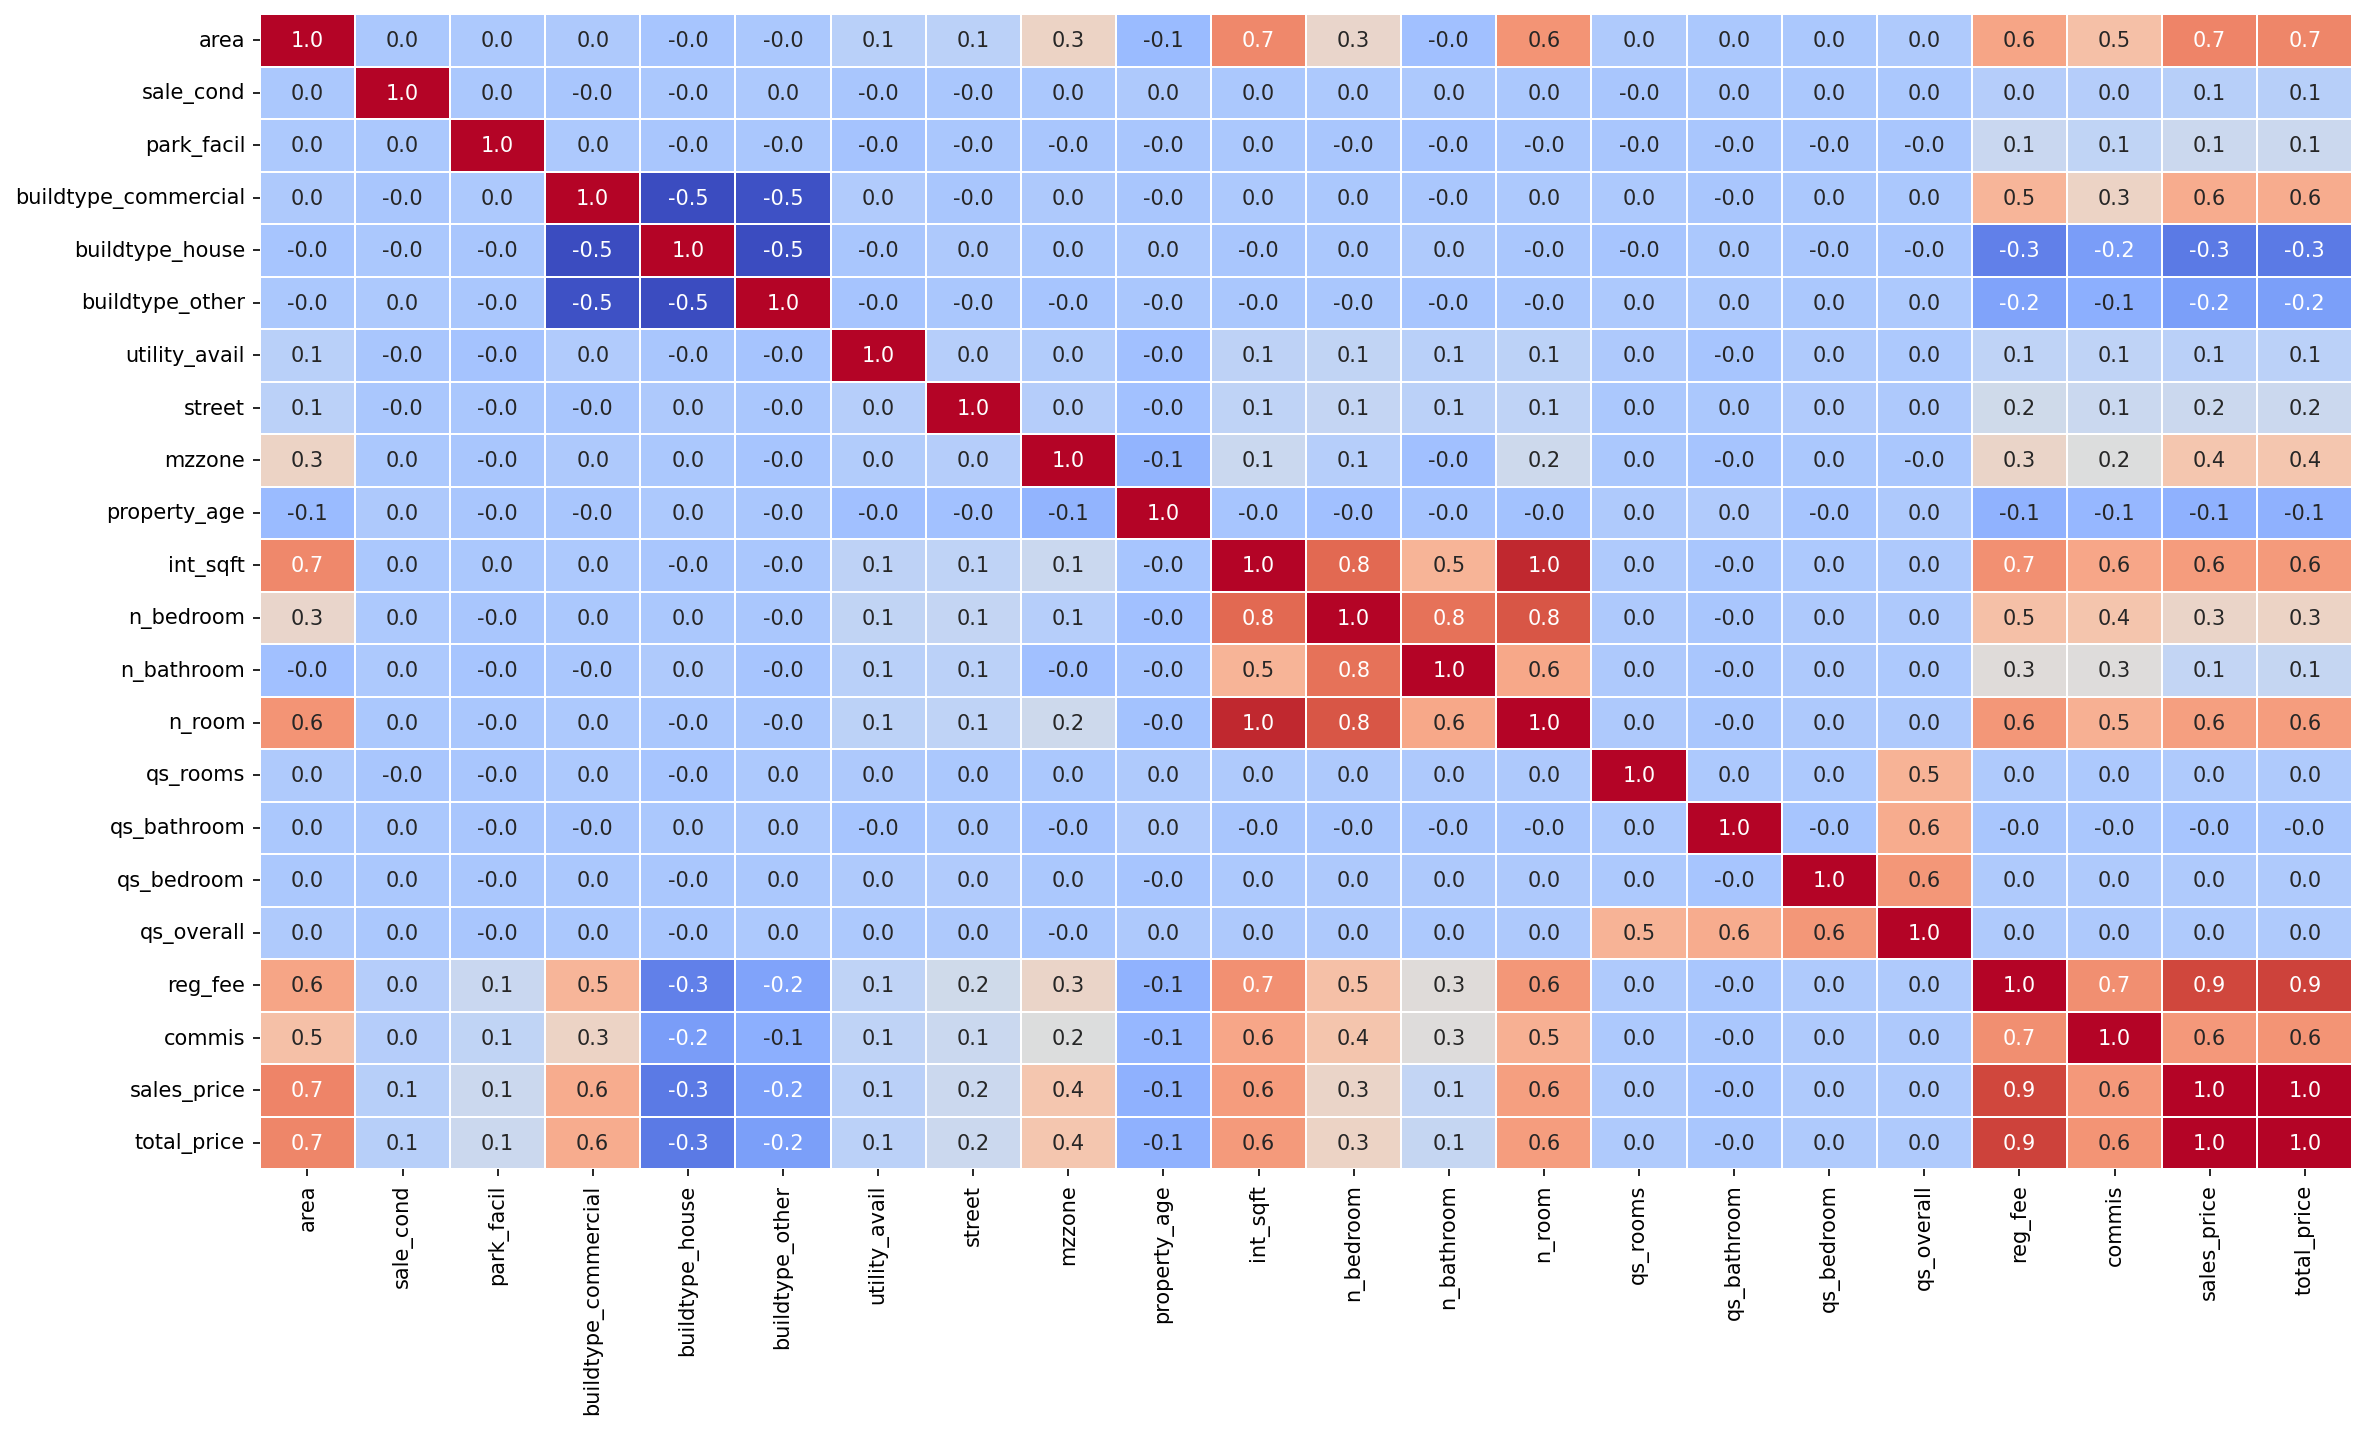

In [32]:



data.area = data.area.map({'karapakkam': 1,
                           'adyar': 2,
                           'chrompet' : 3,
                           'velachery' : 4,
                           'kk nagar' : 5,
                           'anna nagar' : 6,
                           't nagar' : 7})

data.sale_cond = data.sale_cond.map({'partial' : 1,
                                     'family' : 2,
                                     'abnormal' : 3,
                                     'normal sale' : 4,
                                     'adjland' : 5})

data.park_facil = data.park_facil.map({'yes':1,
                                       'no':0})

data.utility_avail = data.utility_avail.map({'elo' : 1,
                                             'nosewa' : 2,
                                             'nosewer ' : 3,
                                             'allpub' : 4})

data.street = data.street.map({'no access' : 1,
                               'paved' : 2,
                               'gravel' : 3})

data.mzzone = data.mzzone.map({'a' : 1,
                               'c' : 2,
                               'i' : 3,
                               'rl' : 5,
                               'rh' : 4,
                               'rm' : 6})

data = data.reindex(columns = ['area', 'sale_cond', 'park_facil',
       'buildtype_commercial', 'buildtype_house','buildtype_other', 'utility_avail',
       'street', 'mzzone', 'property_age', 'int_sqft', 'n_bedroom',
       'n_bathroom', 'n_room', 'qs_rooms', 'qs_bathroom', 'qs_bedroom',
        'qs_overall', 'reg_fee', 'commis', 'sales_price', 'total_price'])

plt.figure(figsize=(18,10), dpi=150)
sns.heatmap(data.corr(method='pearson'), cbar=False, annot=True, fmt='.1f', linewidth=0.2, cmap='coolwarm');

data.head(10)

 Removing unnecessary features thich has negligible relation with total_price

In [33]:
df = data.copy()
df.drop(['qs_overall', 'qs_overall','qs_rooms', 'qs_bathroom', 'qs_bedroom', 'reg_fee',	'commis'], axis=1, inplace=True)
input_cols = ['area', 'sale_cond', 'park_facil', 'buildtype_commercial',	'buildtype_house',
              'buildtype_other', 'utility_avail', 'street', 'mzzone', 'property_age',
              'int_sqft', 'n_bedroom', 'n_bathroom', 'n_room']

target_cols = 'sales_price'
target1_cols = 'total_price'

input = df[input_cols].copy()
target = df[target_cols].copy()
target1 = df[target1_cols].copy()



**Splitting the data for training and testing**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state = 7)

**SCALLING**

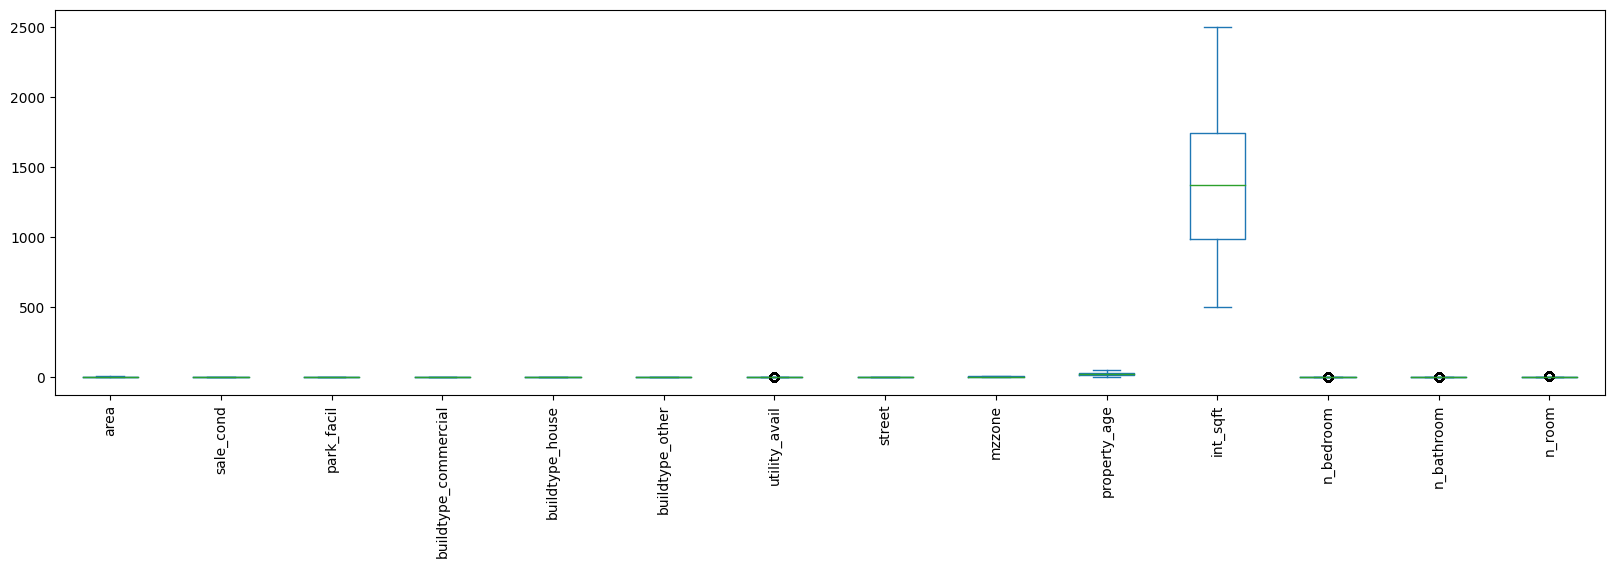

In [35]:
pd.DataFrame(X_train, columns=X_train.columns).plot.box(figsize=(20,5), rot=90)
plt.show()


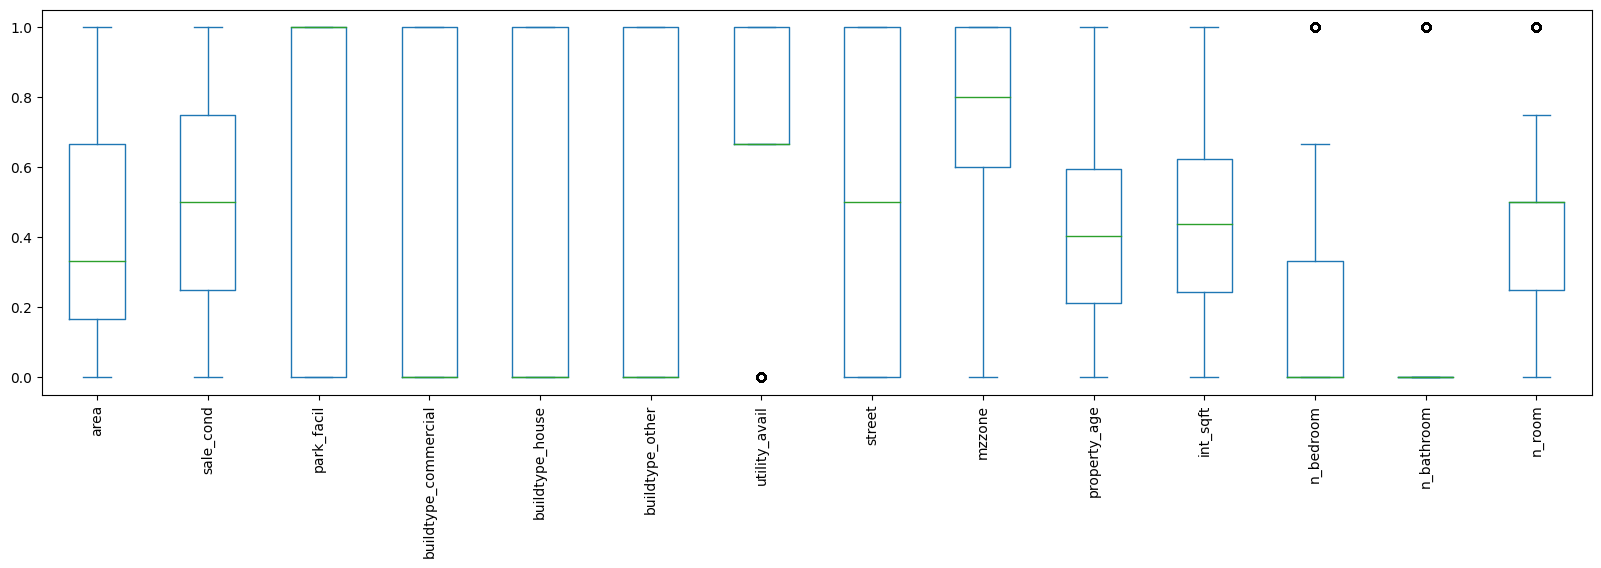

In [36]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=X_train.columns)
X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns=X_test.columns)
X_train_mm.plot.box(figsize=(20,5), rot=90)
plt.show()

**Model training**
#Linear regression(R2 score)

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))



R2- SCORE: 0.9266345831376489
